# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

## Simulation

In [7]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [8]:
sim.step(3600)

3600.0

### Refined Simulation

Defining local area

In [9]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

scale = 1.2

Extract local IC

In [10]:
sim.give_birth(gpu_ctx_refined, loc, scale)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


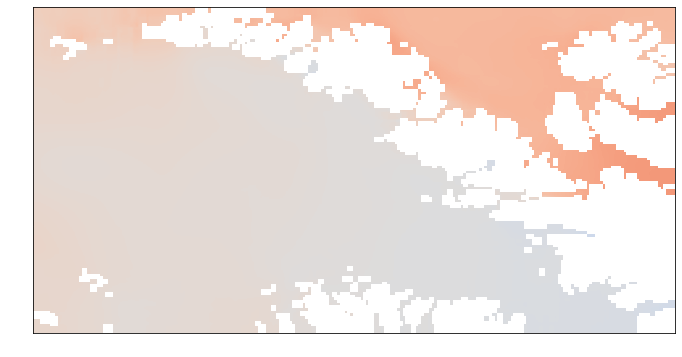

In [11]:
eta, hu, hv = sim.children[0].download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

### Time evolution

In [12]:
sim.step(3600)

7200.0

## Sampling multi-resolution noise

### Sampling noise on finest level

In [13]:
fine_NX = np.ceil((sim.nx+4) * scale).astype(np.int32)
fine_NY = np.ceil((sim.ny+4) * scale).astype(np.int32)

fine_dx = sim.children[-1].dx
fine_dy = sim.children[-1].dy

In [14]:
import pycuda.driver as cuda
stream = cuda.Stream()

from gpuocean.SWEsimulators import Simulator, OceanStateNoise
from importlib import reload
reload(OceanStateNoise)
small_scale_model_error = OceanStateNoise.OceanStateNoise(gpu_ctx, stream, fine_NX, fine_NY, fine_dx, fine_dy, 
                                                            sim.boundary_conditions, staggered=False, interpolation_factor=21, 
                                                            angle=Simulator.Simulator.get_texture(sim, "angle_tex"), 
                                                            coriolis_f=Simulator.Simulator.get_texture(sim, "coriolis_f_tex"))

In [15]:
from gpuocean.utils import Common
eta_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))
dummy_hu_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))
dummy_hv_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))

dummy_fine_bathymetry = Common.Bathymetry(gpu_ctx, sim.gpu_stream, fine_NX, fine_NY, 0, 0, np.ones((fine_NY+1, fine_NX+1)))

small_scale_model_error.perturbOceanState(eta_pert, dummy_hu_pert, dummy_hv_pert, dummy_fine_bathymetry.Bi, 0.0, ghost_cells_x=0, ghost_cells_y=0)


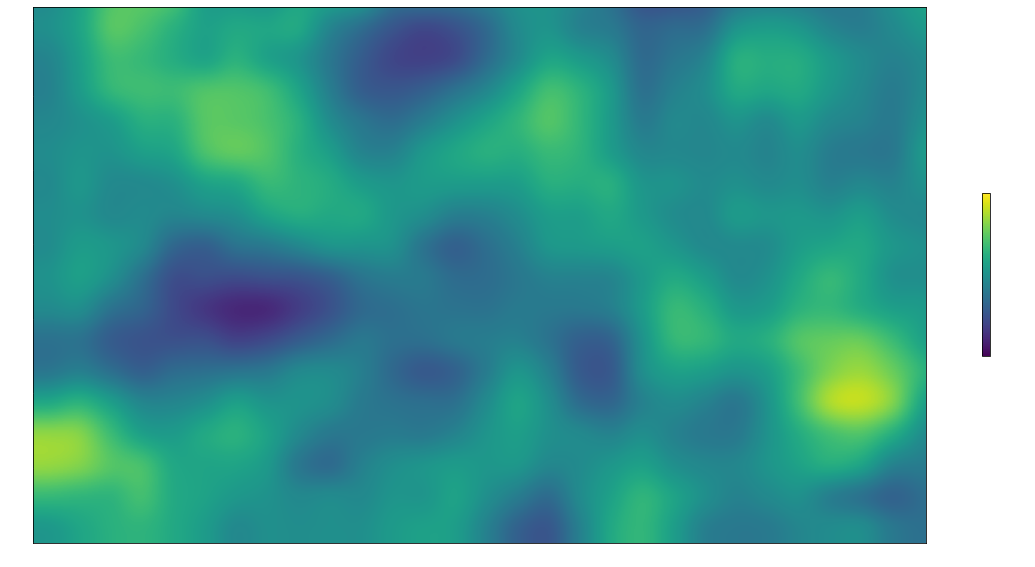

In [16]:
fig, axs = plt.subplots(1,1, figsize=(20,10))
im = axs.imshow(eta_pert.data.get(), vmin=-0.05, vmax=0.05, origin="lower")
# im = axs.imshow(np.roll(eta_pert.data.get(), -2, axis=1))
plt.colorbar(im, ax=axs, shrink=0.3)


### Geostrophic balance on each level: Parent

In [17]:
from gpuocean.utils import OceanographicUtilities
base_H = sim.bathymetry.Bi.data.get()
base_H[base_H==sim.bathymetry.mask_value] = 0
base_H = np.ma.array(base_H, mask=(base_H==0.0))

fine_H = OceanographicUtilities.rescaleIntersections(base_H, fine_NX+1, fine_NY+1)[2]
fine_H = np.ma.array(fine_H, mask=(fine_H==0.0))
fine_bathymetry = Common.Bathymetry(gpu_ctx, sim.gpu_stream, fine_NX, fine_NY, 0, 0, fine_H)

tmp_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))
hu_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))
hv_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))


In [18]:
small_scale_model_error.geostrophicBalanceKernel.prepared_async_call(small_scale_model_error.global_size_geo_balance, small_scale_model_error.local_size, stream,
                                                              np.int32(fine_NX), np.int32(fine_NY),
                                                              np.int32(fine_dx), np.int32(fine_dy),
                                                              np.int32(0.0), np.int32(0.0),

                                                              np.float32(sim.g), np.float32(0.0), np.float32(0.0), np.float32(0.0),

                                                              eta_pert.data.gpudata, eta_pert.pitch,

                                                              tmp_pert.data.gpudata, tmp_pert.pitch,
                                                              hu_pert.data.gpudata, hu_pert.pitch,
                                                              hv_pert.data.gpudata, hv_pert.pitch,
                                                              
                                                              fine_bathymetry.Bi.data.gpudata, fine_bathymetry.Bi.pitch,
                                                              sim.bathymetry.mask_value)

The geostrophic balance kernel requires spatial derivates and is hence not expected to work in the outermost frame

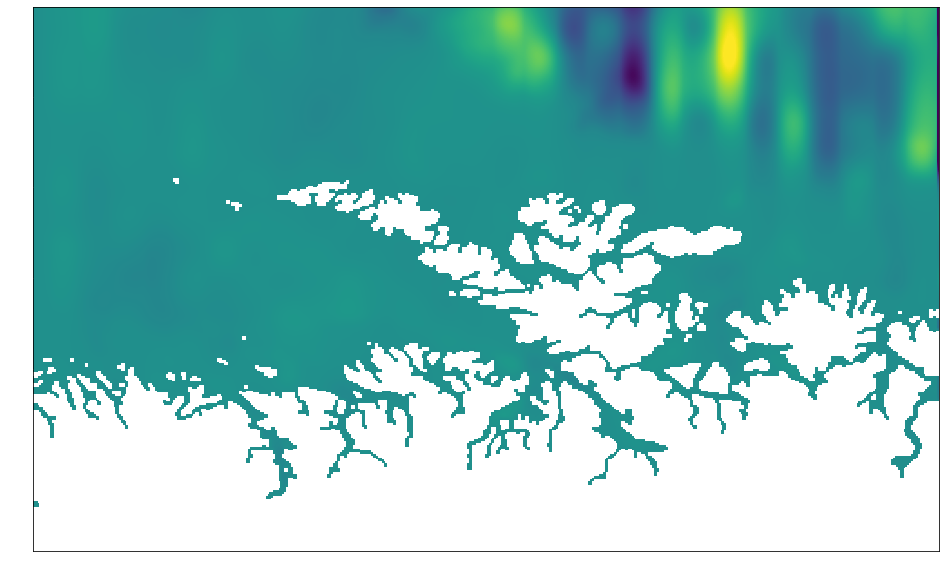

In [19]:
hv_fine_noise   = np.ma.array(hv_pert.data.get(), mask=(fine_bathymetry.Bm.data.get()==fine_bathymetry.mask_value))
hv_coarse_noise = OceanographicUtilities.rescaleMidpoints(hv_fine_noise, sim.nx+4, sim.ny+4)[2]

plt.figure(figsize=(20,10))
plt.imshow(hv_coarse_noise, vmin=-250,vmax=250)
# plt.colorbar()

### Geostrophic balance on each level: Child

In [20]:
level_sim = sim.children[0]

In [21]:
fine_loc = np.round(np.array(loc)*sim.dx/fine_dx, 3)
fine_y0 = fine_loc[0][0]
fine_x0 = fine_loc[0][1]
loc_eta_pert = (1 - fine_x0%1 - fine_y0%1 + fine_x0%1*fine_y0%1) * eta_pert.data.get()[int(fine_y0):int(fine_y0+level_sim.ny+4),int(fine_x0):int(fine_x0+level_sim.nx+4)] \
                +  (fine_x0%1 - fine_x0%1*fine_y0%1) * eta_pert.data.get()[int(fine_y0):int(fine_y0+level_sim.ny+4),int(fine_x0+1):int(fine_x0+level_sim.nx+5)] \
                +  (fine_y0%1 - fine_x0%1*fine_y0%1) * eta_pert.data.get()[int(fine_y0+1):int(fine_y0+level_sim.ny+5),int(fine_x0):int(fine_x0+level_sim.nx+4)] \
                +  fine_x0%1*fine_y0%1 * eta_pert.data.get()[int(fine_y0+1):int(fine_y0+level_sim.ny+5),int(fine_x0+1):int(fine_x0+level_sim.nx+5)]

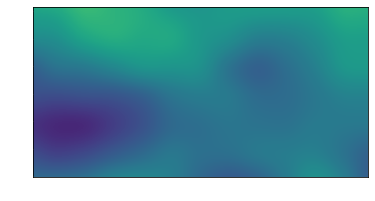

In [22]:
plt.imshow(loc_eta_pert, vmin=-0.05, vmax=0.05, origin="lower")

In [23]:
loc_tmp_pert = Common.CUDAArray2D(stream, level_sim.nx, level_sim.ny, 2,2, np.zeros((level_sim.ny+4, level_sim.nx+4)))
loc_hu_pert = Common.CUDAArray2D(stream, level_sim.nx, level_sim.ny, 2,2, np.zeros((level_sim.ny+4, level_sim.nx+4)))
loc_hv_pert = Common.CUDAArray2D(stream, level_sim.nx, level_sim.ny, 2,2, np.zeros((level_sim.ny+4, level_sim.nx+4)))

In [24]:
loc_eta_pert = Common.CUDAArray2D(stream, level_sim.nx, level_sim.ny, 2, 2, loc_eta_pert)

In [25]:
small_scale_model_error.geostrophicBalanceKernel.prepared_async_call(small_scale_model_error.global_size_geo_balance, small_scale_model_error.local_size, stream,
                                                              np.int32(level_sim.nx), np.int32(level_sim.ny),
                                                              np.int32(level_sim.dx), np.int32(level_sim.dy),
                                                              np.int32(2), np.int32(2),

                                                              np.float32(sim.g), np.float32(0.0), np.float32(0.0), np.float32(0.0),

                                                              loc_eta_pert.data.gpudata, loc_eta_pert.pitch,

                                                              loc_tmp_pert.data.gpudata, loc_tmp_pert.pitch,
                                                              loc_hu_pert.data.gpudata, loc_hu_pert.pitch,
                                                              loc_hv_pert.data.gpudata, loc_hv_pert.pitch,
                                                              
                                                              level_sim.bathymetry.Bi.data.gpudata, level_sim.bathymetry.Bi.pitch,
                                                              level_sim.bathymetry.mask_value)

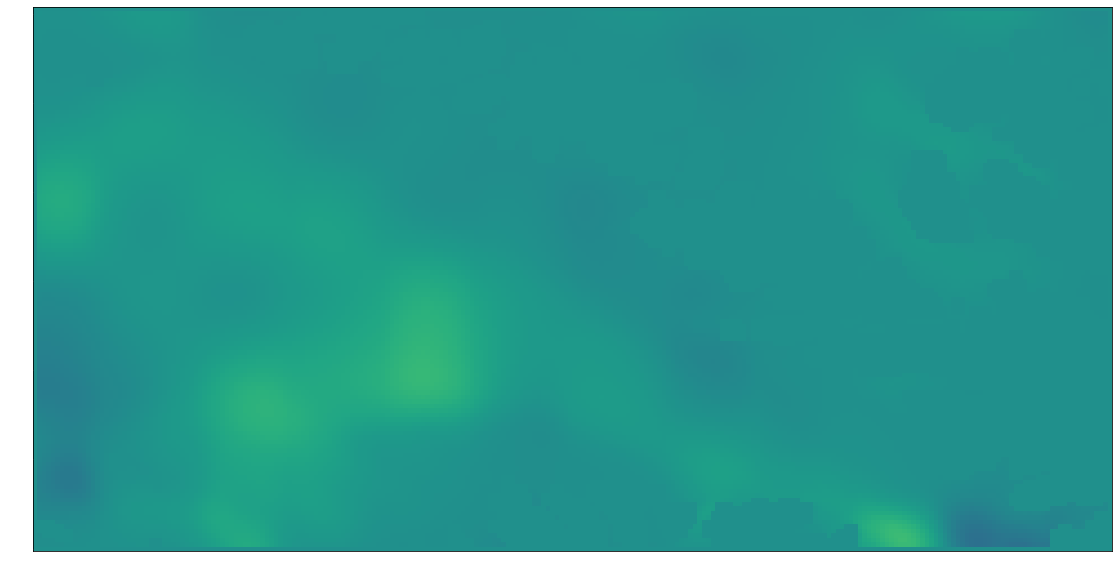

In [27]:
plt.figure(figsize=(20,10))
plt.imshow(loc_hv_pert.data.get()[1:-1,1:-1],origin="lower", vmin=-50,vmax=50)
# plt.colorbar()

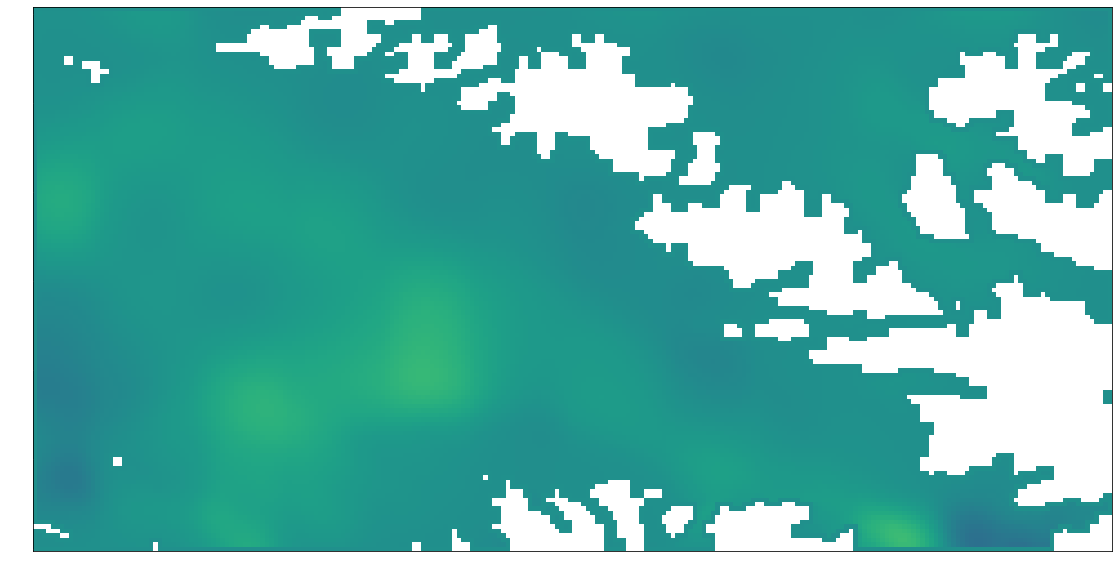

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(np.ma.array(loc_hv_pert.data.get(), mask=(level_sim.bathymetry.Bm.data.get()==level_sim.bathymetry.mask_value))[1:-1,1:-1],origin="lower", vmin=-50,vmax=50)
# plt.colorbar()